In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import CactusDataset
from sklearn.metrics import roc_curve, auc


In [10]:
#use_gpu = torch.cuda.is_available()
#if use_gpu:
#    print("Using CUDA")

In [11]:
data_dir = '../../data/train/train'
csv_file = '../../data/train.csv'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

#set the transforms for the images
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])


torch.manual_seed(42)
image_dataset = CactusDataset.CactusDataset(csv_file, data_dir, data_transforms)
# split into train, eval, test
train_size = int(0.7 * len(image_dataset))
eval_size = int(0.2 * len(image_dataset))
test_size = len(image_dataset) - train_size - eval_size
train_dataset, eval_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, eval_size, test_size])

image_datasets = {TRAIN: train_dataset, VAL: eval_dataset, TEST: test_dataset}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

batch_sizes = {TRAIN: dataset_sizes[TRAIN], VAL: dataset_sizes[VAL], TEST: 64}

dataloaders = {TRAIN: None, VAL: None, TEST: None}
dataloaders[TRAIN] = DataLoader(image_datasets[TRAIN], batch_size=batch_sizes[TRAIN],
                                             shuffle=True, num_workers=0)
dataloaders[VAL] = DataLoader(image_datasets[VAL], batch_size=batch_sizes[VAL],
                                             shuffle=False, num_workers=0)
dataloaders[TEST] = DataLoader(image_datasets[TEST], batch_size=batch_sizes[TEST], shuffle=False, num_workers=0)


print(dataset_sizes)
class_names = {0: 'No Cactus', 1: 'Cactus'}

inputs, classes = next(iter(dataloaders[TRAIN]))
print(inputs[0])

n_features = 32 * 32 * 3

print(n_features)

#print nunmber of each class in each dataset
for x in [TRAIN, VAL, TEST]:
    print("Number of {} images: {}".format(x, dataset_sizes[x]))
    for i in range(2):
        print("Number of {} images of class {}: {}".format(x, class_names[i], sum([1 for j in image_datasets[x] if j[1] == i])))
    print()




{'train': 12250, 'val': 3500, 'test': 1750}
tensor([[[0.3333, 0.4549, 0.4353,  ..., 0.3098, 0.2980, 0.2353],
         [0.5333, 0.5490, 0.1020,  ..., 0.3843, 0.4118, 0.4078],
         [0.5294, 0.5059, 0.3804,  ..., 0.1294, 0.6784, 0.3098],
         ...,
         [0.5765, 0.4078, 0.4431,  ..., 0.4706, 0.4941, 0.5216],
         [0.4392, 0.4549, 0.3216,  ..., 0.5373, 0.3490, 0.2275],
         [0.3412, 0.5294, 0.3608,  ..., 0.2745, 0.4510, 0.2863]],

        [[0.3176, 0.4392, 0.4196,  ..., 0.2627, 0.2549, 0.1922],
         [0.5176, 0.5333, 0.0863,  ..., 0.3412, 0.3686, 0.3647],
         [0.5137, 0.4902, 0.3647,  ..., 0.0902, 0.6392, 0.2784],
         ...,
         [0.5961, 0.4275, 0.4627,  ..., 0.4863, 0.5216, 0.5569],
         [0.4510, 0.4667, 0.3333,  ..., 0.5647, 0.3843, 0.2706],
         [0.3529, 0.5412, 0.3725,  ..., 0.3098, 0.4863, 0.3294]],

        [[0.2745, 0.3961, 0.3765,  ..., 0.3176, 0.3098, 0.2471],
         [0.4745, 0.4902, 0.0431,  ..., 0.3961, 0.4235, 0.4196],
         [0.46

In [12]:
# Create model
# f = wx + b, sigmoid at the end
class LogisticRegression(nn.Module):

    def __init__(self, n_input_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_predicted = torch.sigmoid(self.linear(x))
        return y_predicted

In [13]:
def train_model(model, criterion, optimizer, model_name, X_train, y_train, X_val, y_val, transforms=None, num_epochs=1000):
    # training loop
    num_epochs = num_epochs
    epoch_best = 0
    f1_scores = []
    accs_train = []
    accs_val = []
    aucs = []
    best_fpr = []
    best_tpr = []
    best_auc = 0
    best_acc = 0
    best_f1 = 0
    

    #40k epoche runnate
    for epoch in range(num_epochs):
        #randomly horizontal flip the images in X_train
        if transforms is not None:
            X_train = transforms(X_train)
        #use mini batches
        # forward pass and loss
        outputs = model(X_train)
        #make y_predicted and y_train of same shape
        outputs = outputs.view(-1)

        preds = outputs.round()
        acc_train = (preds == y_train).sum() / y_train.shape[0]
        accs_train.append(acc_train)

        loss = criterion(outputs, y_train.float())
        
        # backward pass
        loss.backward()
        
        # updates
        optimizer.step()
        
        # zero gradients
        optimizer.zero_grad()
        
        with torch.no_grad():
            outputs = model(X_val)  # no need to call model.forward()
            y_predicted_cls = outputs.round()   # round off to nearest class
            #flatten
            y_val = y_val.view(-1)
            y_predicted_cls = y_predicted_cls.view(-1)

            #Compute f1 score
            tp = (y_val * y_predicted_cls).sum()
            tn = ((1 - y_val) * (1 - y_predicted_cls)).sum()
            fp = ((1 - y_val) * y_predicted_cls).sum()
            fn = (y_val * (1 - y_predicted_cls)).sum()
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = 2 * precision * recall / (precision + recall)
            f1_scores.append(f1)

            #Compute accuracy
            acc = (y_predicted_cls == y_val).sum() / y_val.shape[0]   # accuracy
            accs_val.append(acc)

            #Compute AUC
            fpr, tpr, _ = roc_curve(y_val, outputs)
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            
            if roc_auc > best_auc:
                best_auc = roc_auc
                best_fpr = fpr
                best_tpr = tpr
                epoch_best = epoch
            if f1 > best_f1:
                best_f1 = f1
            if acc > best_acc:
                best_acc = acc

            if epoch % 100 == 0:
                print(f'Epoch: {epoch}, Loss: {loss.item()}, Accuracy on val: {acc}, F1 score on val: {f1}, AUC on val: {roc_auc}')
    return accs_train, accs_val, aucs, f1_scores, best_fpr, best_tpr, best_auc, best_f1, epoch_best

## LR without PCA

In [14]:

#Load dataset, we flatten the images and we put them in a single numpy array in memory of shape (n_images, n_features)
X_train = []
y_train = []
for images, labels in dataloaders[TRAIN]:
    images = images.view(-1, n_features)
    X_train.append(images)
    y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)
X_val = []
y_val = []
for images, labels in dataloaders[VAL]:
    images = images.view(-1, n_features)
    X_val.append(images)
    y_val.append(labels)
X_val = torch.cat(X_val, dim=0)
y_val = torch.cat(y_val, dim=0)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_train[0])
n_features = X_train.shape[1]

torch.Size([12250, 3072])
torch.Size([12250])
torch.Size([3500, 3072])
torch.Size([3500])
tensor([0.5098, 0.4549, 0.4078,  ..., 0.4118, 0.5255, 0.4745])


In [15]:
#instantiate model
model = LogisticRegression(n_features)
print("Number of parameters in the model: "+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# Loss and optimizer
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Number of parameters in the model: 3073


Epoch: 0, Loss: 0.809251606464386, Accuracy on val: 0.2525714337825775, F1 score on val: 0.020958084613084793, AUC on val: 0.6342572055226434
Epoch: 100, Loss: 0.5318897366523743, Accuracy on val: 0.7554285526275635, F1 score on val: 0.8606770634651184, AUC on val: 0.6982009169058492
Epoch: 200, Loss: 0.49740755558013916, Accuracy on val: 0.7654285430908203, F1 score on val: 0.865122377872467, AUC on val: 0.7885785750137855
Epoch: 300, Loss: 0.4724642336368561, Accuracy on val: 0.7739999890327454, F1 score on val: 0.8669917583465576, AUC on val: 0.8207191030299603
Epoch: 400, Loss: 0.45388391613960266, Accuracy on val: 0.7771428823471069, F1 score on val: 0.8669849634170532, AUC on val: 0.8366867497561045
Epoch: 500, Loss: 0.43962159752845764, Accuracy on val: 0.7760000228881836, F1 score on val: 0.8645473122596741, AUC on val: 0.8462159076448881
Epoch: 600, Loss: 0.4283594489097595, Accuracy on val: 0.7845714092254639, F1 score on val: 0.8682279586791992, AUC on val: 0.852897850184512

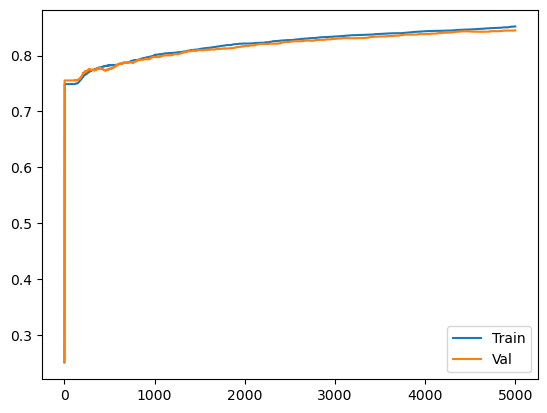

In [16]:
# train model for 5000 epochs
accs_train, accs_val, aucs, f1_scores, best_fpr, best_tpr, best_auc, best_f1, epoch_best = train_model(model, criterion, optimizer, 'LR', X_train, y_train, X_val, y_val, num_epochs=5000)
print(f'Best AUC: {best_auc}, Best F1: {best_f1}, Best epoch: {epoch_best}')
#plot accuracies of val and training
plt.plot(accs_train, label='Train')
plt.plot(accs_val, label='Val')
plt.legend()
plt.show()

## LR with PCA

In [17]:
from sklearn.decomposition import PCA

In [18]:
#Load dataset, we flatten the images and we put them in a single numpy array in memory of shape (n_images, n_features)
X_train = []
y_train = []
for images, labels in dataloaders[TRAIN]:
    images = images.view(-1, n_features)
    X_train.append(images)
    y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)
X_val = []
y_val = []
for images, labels in dataloaders[VAL]:
    images = images.view(-1, n_features)
    X_val.append(images)
    y_val.append(labels)
X_val = torch.cat(X_val, dim=0)
y_val = torch.cat(y_val, dim=0)

In [19]:
# retain only n_componenets feature with highest variance using PCA
n_components = 612
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train.detach().numpy())
X_val_pca = pca.transform(X_val.detach().numpy())
#transform in tensors
X_train_pca = torch.tensor(X_train_pca)
X_val_pca = torch.tensor(X_val_pca)


In [20]:
model = LogisticRegression(X_train_pca.shape[1])
# Loss and optimizer
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch: 0, Loss: 0.7104105353355408, Accuracy on val: 0.4251428544521332, F1 score on val: 0.5441775918006897, AUC on val: 0.3811314102110933
Epoch: 100, Loss: 0.5963813662528992, Accuracy on val: 0.8022857308387756, F1 score on val: 0.8683409094810486, AUC on val: 0.8348946477300039
Epoch: 200, Loss: 0.5247758030891418, Accuracy on val: 0.8571428656578064, F1 score on val: 0.9076467752456665, AUC on val: 0.9035110353895967
Epoch: 300, Loss: 0.4764160215854645, Accuracy on val: 0.8674286007881165, F1 score on val: 0.9146431088447571, AUC on val: 0.9208669426103185
Epoch: 400, Loss: 0.44207969307899475, Accuracy on val: 0.8711428642272949, F1 score on val: 0.9170804023742676, AUC on val: 0.927554629066693
Epoch: 500, Loss: 0.41660454869270325, Accuracy on val: 0.87371426820755, F1 score on val: 0.9185703992843628, AUC on val: 0.9308944957371301
Epoch: 600, Loss: 0.39700525999069214, Accuracy on val: 0.8751428723335266, F1 score on val: 0.9193875193595886, AUC on val: 0.9328922741668669
E

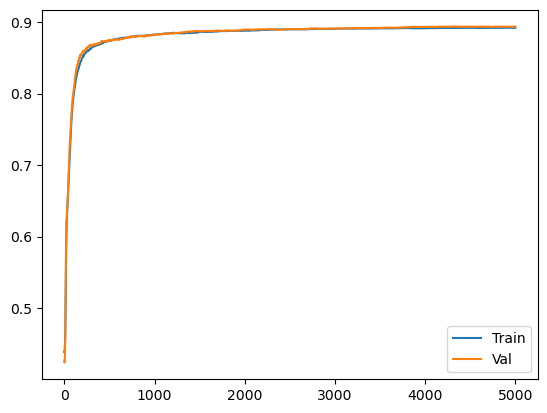

In [21]:
#Train model using pca features
accs_train, accs_val, aucs, f1_scores, best_fpr, best_tpr, best_auc, best_f1, epoch_best = train_model(model, criterion, optimizer, 'LR', X_train_pca, y_train, X_val_pca, y_val, num_epochs=5000)
print(f'Best AUC: {best_auc}, Best F1: {best_f1}, Best epoch: {epoch_best}')
#plot accuracies of val and training
plt.plot(accs_train, label='Train')
plt.plot(accs_val, label='Val')
plt.legend()
plt.show()


## LR with data standardization and PCA

In [22]:
from sklearn.decomposition import PCA

In [23]:
X_train = []
y_train = []
for images, labels in dataloaders[TRAIN]:
    
    images = images.view(-1, n_features)
    X_train.append(images)
    y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)
X_val = []
y_val = []
for images, labels in dataloaders[VAL]:
    images = images.view(-1, n_features)
    X_val.append(images)
    y_val.append(labels)
X_val = torch.cat(X_val, dim=0)
y_val = torch.cat(y_val, dim=0)

In [24]:
# retain only n_componenets feature with highest variance using PCA
n_components = 612
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train.detach().numpy())
X_val_pca = pca.transform(X_val.detach().numpy())
#transform in tensors
print(X_train_pca.shape)
X_train_pca = torch.tensor(X_train_pca)
X_val_pca = torch.tensor(X_val_pca)

#compute mean of X_train_pca
mean = X_train_pca.mean().item()
std = X_train_pca.std().item()

print(mean)
print(std)

#standardize X_train_pca and X_val_pca using mean and std
X_train_pca = (X_train_pca - mean) / std
X_val_pca = (X_val_pca - mean) / std


(12250, 612)
-1.1397788268752151e-10
0.3217460811138153


In [33]:

model = LogisticRegression(X_train_pca.shape[1])
print("Number of parameters in the model: "+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# Loss and optimizer
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Number of parameters in the model: 613


Epoch: 0, Loss: 0.7349820733070374, Accuracy on val: 0.5208571553230286, F1 score on val: 0.6159834861755371, AUC on val: 0.5241319616271014
Epoch: 100, Loss: 0.4757404029369354, Accuracy on val: 0.7991428375244141, F1 score on val: 0.8501385450363159, AUC on val: 0.9278860088792116
Epoch: 200, Loss: 0.41707274317741394, Accuracy on val: 0.8334285616874695, F1 score on val: 0.8792710900306702, AUC on val: 0.9356142279468944
Epoch: 300, Loss: 0.38271957635879517, Accuracy on val: 0.8534285426139832, F1 score on val: 0.8955405950546265, AUC on val: 0.9381972231255391
Epoch: 400, Loss: 0.3583419919013977, Accuracy on val: 0.8665714263916016, F1 score on val: 0.9063189625740051, AUC on val: 0.9396552943006208
Epoch: 500, Loss: 0.34001797437667847, Accuracy on val: 0.8774285912513733, F1 score on val: 0.914762556552887, AUC on val: 0.940639713263676
Epoch: 600, Loss: 0.3258034288883209, Accuracy on val: 0.8825713992118835, F1 score on val: 0.9189828634262085, AUC on val: 0.9413139607222136


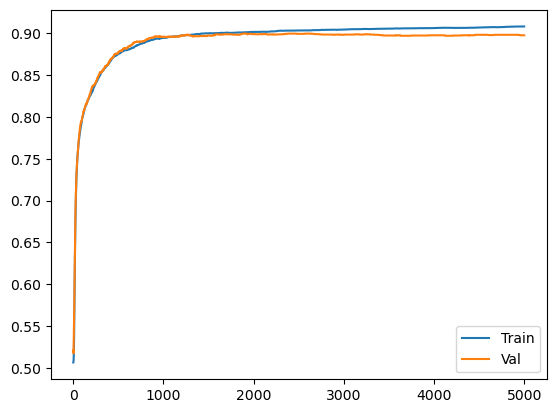

In [26]:

#Train model using pca features
accs_train, accs_val, aucs, f1_scores, best_fpr, best_tpr, best_auc, best_f1, epoch_best = train_model(model, criterion, optimizer, 'LR', X_train_pca, y_train, X_val_pca, y_val, num_epochs=5000)
print(f'Best AUC: {best_auc}, Best F1: {best_f1}, Best epoch: {epoch_best}')
#plot accuracies of val and training
plt.plot(accs_train, label='Train')
plt.plot(accs_val, label='Val')
plt.legend()
plt.show()


In [29]:
# show memory occupation of the model
# save model on memory
torch.save(model, '../../data/LRmodel.pth')

In [30]:
from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        model(X_val_pca)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

----------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
----------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
       model_inference        23.08%     668.000us       100.00%       2.894ms       2.894ms           0 b     -27.34 Kb             1  
          aten::linear         6.19%     179.000us        76.05%       2.201ms       2.201ms      13.67 Kb           0 b             1  
               aten::t        32.69%     946.000us        40.26%       1.165ms       1.165ms           0 b           0 b             1  
           aten::addmm        28.99%     839.000us        29.61%     857.000us     857.000us      13.67 Kb      13.67 Kb             1  
       aten::transpose         7.43%     

STAGE:2024-05-02 16:50:47 13129:13129 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-02 16:50:47 13129:13129 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-02 16:50:47 13129:13129 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


## LR with PCA, normalization and histogram equalization

In [31]:
from sklearn.decomposition import PCA

In [32]:
data_dir = '../../../data/train/train'
csv_file = '../../../data/train.csv'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

#set the transforms for the images
data_transforms = transforms.Compose([
    transforms.RandomEqualize(p=1),
    transforms.ToTensor(),
])


torch.manual_seed(42)
image_dataset = CactusDataset.CactusDataset(csv_file, data_dir, data_transforms)
# split into train, eval, test
train_size = int(0.7 * len(image_dataset))
eval_size = int(0.2 * len(image_dataset))
test_size = len(image_dataset) - train_size - eval_size
train_dataset, eval_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, eval_size, test_size])


FileNotFoundError: [Errno 2] No such file or directory: '../../../data/train.csv'

In [ ]:
X_train = []
y_train = []
dataloader = DataLoader(train_dataset, batch_size=train_size, shuffle=True, num_workers=0)
for images, labels in dataloader:
    images = images.view(-1, n_features)
    X_train.append(images)
    y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)
X_val = []
y_val = []
dataloader = DataLoader(eval_dataset, batch_size=eval_size, shuffle=False, num_workers=0)
for images, labels in dataloader:
    images = images.view(-1, n_features)
    X_val.append(images)
    y_val.append(labels)
X_val = torch.cat(X_val, dim=0)
y_val = torch.cat(y_val, dim=0)

In [ ]:
pca = PCA(n_components=X_train.shape[1])
pca.fit(X_train)
#plot number of features vs explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.99)
plt.scatter(n_components, 0.99, color='r')
plt.text(n_components, 0.99, '({}, {})'.format(n_components, 0.99), color='black')

plt.show()

#print n_components for 95% variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.99)
print('Number of components for 95% variance: ', n_components)

# retain only n_componenets feature with highest variance using PCA
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train.detach().numpy())
X_val_pca = pca.transform(X_val.detach().numpy())
#transform in tensors
print(X_train_pca.shape)
X_train_pca = torch.tensor(X_train_pca)
X_val_pca = torch.tensor(X_val_pca)

#compute mean of X_train_pca
mean = X_train_pca.mean().item()
std = X_train_pca.std().item()

print(mean)
print(std)

#standardize X_train_pca and X_val_pca using mean and std
X_train_pca = (X_train_pca - mean) / std
X_val_pca = (X_val_pca - mean) / std


In [ ]:
model = LogisticRegression(X_train_pca.shape[1])
# Loss and optimizer
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
#Train model using pca features
accs_train, accs_val, aucs, f1_scores, best_fpr, best_tpr, best_auc, best_f1, epoch_best = train_model(model, criterion, optimizer, 'LR', X_train_pca, y_train, X_val_pca, y_val, num_epochs=5000)
print(f'Best AUC: {best_auc}, Best F1: {best_f1}, Best epoch: {epoch_best}')
#plot accuracies of val and training
plt.plot(accs_train, label='Train')
plt.plot(accs_val, label='Val')
plt.legend()
plt.show()


## LR with oversampling

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
data_dir = '../../../data/train/train'
csv_file = '../../../data/train.csv'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

#set the transforms for the images
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])


torch.manual_seed(42)
image_dataset = CactusDataset.CactusDataset(csv_file, data_dir, data_transforms)
print(image_dataset.get_class_distribution())


image_dataset.oversample()
print(len(image_dataset))

# print number of classes
print(image_dataset.get_class_distribution())

# split into train, eval, test
train_size = int(0.7 * len(image_dataset))
eval_size = int(0.2 * len(image_dataset))
test_size = len(image_dataset) - train_size - eval_size
train_dataset, eval_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, eval_size, test_size])

n_features = 32 * 32 * 3

In [ ]:
X_train = []
y_train = []
dataloader = DataLoader(train_dataset, batch_size=train_size, shuffle=True, num_workers=0)
for images, labels in dataloader:
    images = images.view(-1, n_features)
    X_train.append(images)
    y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)
X_val = []
y_val = []
dataloader = DataLoader(eval_dataset, batch_size=eval_size, shuffle=False, num_workers=0)
for images, labels in dataloader:
    images = images.view(-1, n_features)
    X_val.append(images)
    y_val.append(labels)
X_val = torch.cat(X_val, dim=0)
y_val = torch.cat(y_val, dim=0)
n_features = X_train.shape[1]

In [ ]:
# retain only n_componenets feature with highest variance using PCA
n_components = 612
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train.detach().numpy())
X_val_pca = pca.transform(X_val.detach().numpy())
#transform in tensors
X_train_pca = torch.tensor(X_train_pca)
X_val_pca = torch.tensor(X_val_pca)

#Standardize
mean = X_train_pca.mean().item()
std = X_train_pca.std().item()
X_train_pca = (X_train_pca - mean) / std
X_val_pca = (X_val_pca - mean) / std

In [ ]:
#instantiate model
model = LogisticRegression(n_components)
# Loss and optimizer
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
# train model for 5000 epochs
accs_train, accs_val, aucs, f1_scores, best_fpr, best_tpr, best_auc, best_f1, epoch_best = train_model(model, criterion, optimizer, 'LR', X_train_pca, y_train, X_val_pca, y_val, num_epochs=5000)
print(f'Best AUC: {best_auc}, Best F1: {best_f1}, Best epoch: {epoch_best}')
#plot accuracies of val and training
plt.plot(accs_train, label='Train')
plt.plot(accs_val, label='Val')
plt.legend()
plt.show()